# Final

### Computer Vision 

In [1]:
import os
import cv2
import numpy as np
from skimage.filters import frangi
import matplotlib.pyplot as plt
from glob import glob

def preprocess_leaf_image(image_path, output_size=(224, 224)):
    """
    Preprocess a leaf image to extract RGB, venation map, and edge map
    
    Args:
        image_path (str): Path to the leaf image
        output_size (tuple): Size to resize images to (height, width)
        
    Returns:
        tuple: (RGB image, venation map, edge map)
    """
    # Read the original image
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    # 1. RGB Image Extraction
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    rgb_image = cv2.resize(rgb_image, output_size)
    
    # 2. Venation Map Extraction
    # Convert to grayscale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, output_size)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)
    
    # Apply Frangi filter to enhance vein-like structures
    # Updated parameters to be compatible with current scikit-image version
    venation_map = frangi(clahe_image, 
                         scale_range=(1, 3), 
                         scale_step=0.5,
                         beta=15,  # Using beta instead of beta1/beta2
                         black_ridges=False)
    
    # Normalize the venation map
    venation_map = cv2.normalize(venation_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # 3. Edge Map Extraction using Canny edge detection
    edge_map = cv2.Canny(gray_image, 50, 150)
    
    return rgb_image, venation_map, edge_map

def process_dataset(dataset_path, output_dir):
    """
    Process an entire dataset of leaf images
    
    Args:
        dataset_path (str): Path to the dataset directory
        output_dir (str): Directory to save processed images
    """
    # Create output directories if they don't exist
    os.makedirs(os.path.join(output_dir, 'rgb'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'venation'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'edge'), exist_ok=True)
    
    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob(os.path.join(dataset_path, '**', ext), recursive=True))
    
    print(f"Found {len(image_files)} images to process")
    
    for idx, image_path in enumerate(image_files):
        try:
            # Extract class from path (assuming dataset structure: dataset/class/image.jpg)
            # Handle paths with spaces correctly
            path_parts = os.path.normpath(image_path).split(os.sep)
            class_name = path_parts[-2]  # Assuming last directory is the class name
            file_name = os.path.basename(image_path)
            
            # Create class directories if they don't exist
            os.makedirs(os.path.join(output_dir, 'rgb', class_name), exist_ok=True)
            os.makedirs(os.path.join(output_dir, 'venation', class_name), exist_ok=True)
            os.makedirs(os.path.join(output_dir, 'edge', class_name), exist_ok=True)
            
            # Process the image
            rgb_image, venation_map, edge_map = preprocess_leaf_image(image_path)
            
            # Save processed images
            cv2.imwrite(os.path.join(output_dir, 'rgb', class_name, file_name), 
                        cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(output_dir, 'venation', class_name, file_name), venation_map)
            cv2.imwrite(os.path.join(output_dir, 'edge', class_name, file_name), edge_map)
            
            if idx % 100 == 0:
                print(f"Processed {idx}/{len(image_files)} images")
                
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

def visualize_preprocessing(image_path):
    """
    Visualize the preprocessing steps for a single image
    
    Args:
        image_path (str): Path to the leaf image
    """
    rgb_image, venation_map, edge_map = preprocess_leaf_image(image_path)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_image)
    plt.title('RGB Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(venation_map, cmap='gray')
    plt.title('Venation Map')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(edge_map, cmap='gray')
    plt.title('Edge Map')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to check scikit-image version and available parameters
def check_frangi_parameters():
    """
    Print the available parameters for the frangi function
    """
    import inspect
    from skimage import __version__ as skimage_version
    
    print(f"scikit-image version: {skimage_version}")
    print("Frangi function parameters:")
    print(inspect.signature(frangi))
    print("For more details, refer to the documentation at:")
    print("https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.frangi")

# Example usage
if __name__ == "__main__":
    # Check frangi parameters to diagnose issues
    check_frangi_parameters()
    
    # Path to the Mendeley leaf dataset
    dataset_path = "Medicinal Leaf Dataset/Segmented Medicinal Leaf Images"
    output_dir = "Output"
    
    # Process the entire dataset
    process_dataset(dataset_path, output_dir)
    
    # Alternatively, visualize preprocessing for a single image
    # sample_image = "/Users/arnavkarnik/Documents/Recognition-of-Medicinal-Plant-Species-Deep-Learning-Project--Sem6/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/Punica Granatum (Pomegranate)/PG-S-022.jpg"
    # visualize_preprocessing(sample_image)

scikit-image version: 0.24.0
Frangi function parameters:
(image, sigmas=range(1, 10, 2), scale_range=None, scale_step=None, alpha=0.5, beta=0.5, gamma=None, black_ridges=True, mode='reflect', cval=0)
For more details, refer to the documentation at:
https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.frangi
Found 1835 images to process


C:\Users\nikn\AppData\Local\Temp\ipykernel_41988\1761988498.py:39: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  venation_map = frangi(clahe_image,


Processed 0/1835 images
Processed 100/1835 images
Processed 200/1835 images
Processed 300/1835 images
Processed 400/1835 images
Processed 500/1835 images
Processed 600/1835 images
Processed 700/1835 images
Processed 800/1835 images
Processed 900/1835 images
Processed 1000/1835 images
Processed 1100/1835 images
Processed 1200/1835 images
Processed 1300/1835 images
Processed 1400/1835 images
Processed 1500/1835 images
Processed 1600/1835 images
Processed 1700/1835 images
Processed 1800/1835 images


# Model 3

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim import Adam

class DualStreamCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DualStreamCNN, self).__init__()
        
        # RGB Stream
        self.rgb_conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.rgb_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.rgb_pool = nn.MaxPool2d(2, 2)
        
        # Structural Feature Stream
        self.structure_conv1 = nn.Conv2d(6, 32, kernel_size=3, padding=1)
        self.structure_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.structure_pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 56 * 56 * 2, 128)  # Adjusted based on input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, rgb_input, structure_input):
        # RGB Stream
        x1 = F.relu(self.rgb_conv1(rgb_input))
        x1 = self.rgb_pool(x1)
        x1 = F.relu(self.rgb_conv2(x1))
        x1 = self.rgb_pool(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten
        
        # Structural Feature Stream
        x2 = F.relu(self.structure_conv1(structure_input))
        x2 = self.structure_pool(x2)
        x2 = F.relu(self.structure_conv2(x2))
        x2 = self.structure_pool(x2)
        x2 = x2.view(x2.size(0), -1)  # Flatten
        
        # Merge streams
        merged = torch.cat((x1, x2), dim=1)
        merged = F.relu(self.fc1(merged))
        merged = self.dropout(merged)
        output = self.fc2(merged)
        return output

# Define model and optimizer
def build_model(num_classes=10):
    model = DualStreamCNN(num_classes=num_classes)
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion

# Example usage
model, optimizer, criterion = build_model(num_classes=10)
print(model)

DualStreamCNN(
  (rgb_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgb_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgb_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (structure_conv1): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (structure_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (structure_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset

class DualStreamFolderDataset(Dataset):
    def __init__(self, rgb_root, edge_root, venation_root, transform=None):
        self.rgb_root = rgb_root
        self.edge_root = edge_root
        self.venation_root = venation_root
        self.transform = transform

        self.samples = []
        self.class_to_idx = {}
        self._make_dataset()

    def _make_dataset(self):
        class_names = sorted(os.listdir(self.rgb_root))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

        for cls_name in class_names:
            rgb_cls = os.path.join(self.rgb_root, cls_name)
            edge_cls = os.path.join(self.edge_root, cls_name)
            ven_cls = os.path.join(self.venation_root, cls_name)

            for img_name in os.listdir(rgb_cls):
                rgb_path = os.path.join(rgb_cls, img_name)
                edge_path = os.path.join(edge_cls, img_name)
                ven_path = os.path.join(ven_cls, img_name)

                if all(map(os.path.isfile, [rgb_path, edge_path, ven_path])):
                    label = self.class_to_idx[cls_name]
                    self.samples.append((rgb_path, edge_path, ven_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgb_path, edge_path, ven_path, label = self.samples[idx]
        rgb_img = Image.open(rgb_path).convert("RGB")
        edge_img = Image.open(edge_path).convert("RGB")
        ven_img = Image.open(ven_path).convert("RGB")

        if self.transform:
            rgb_img = self.transform(rgb_img)
            edge_img = self.transform(edge_img)
            ven_img = self.transform(ven_img)

        structure_input = torch.cat([edge_img, ven_img], dim=0)
        return rgb_img, structure_input, label


In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for rgb_inputs, structure_inputs, labels in dataloader:
        rgb_inputs = rgb_inputs.to(device)
        structure_inputs = structure_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(rgb_inputs, structure_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    eval_loss = 0.0

    with torch.no_grad():
        for rgb_inputs, structure_inputs, labels in dataloader:
            rgb_inputs = rgb_inputs.to(device)
            structure_inputs = structure_inputs.to(device)
            labels = labels.to(device)

            outputs = model(rgb_inputs, structure_inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * labels.size(0)

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return eval_loss / len(dataloader.dataset), acc



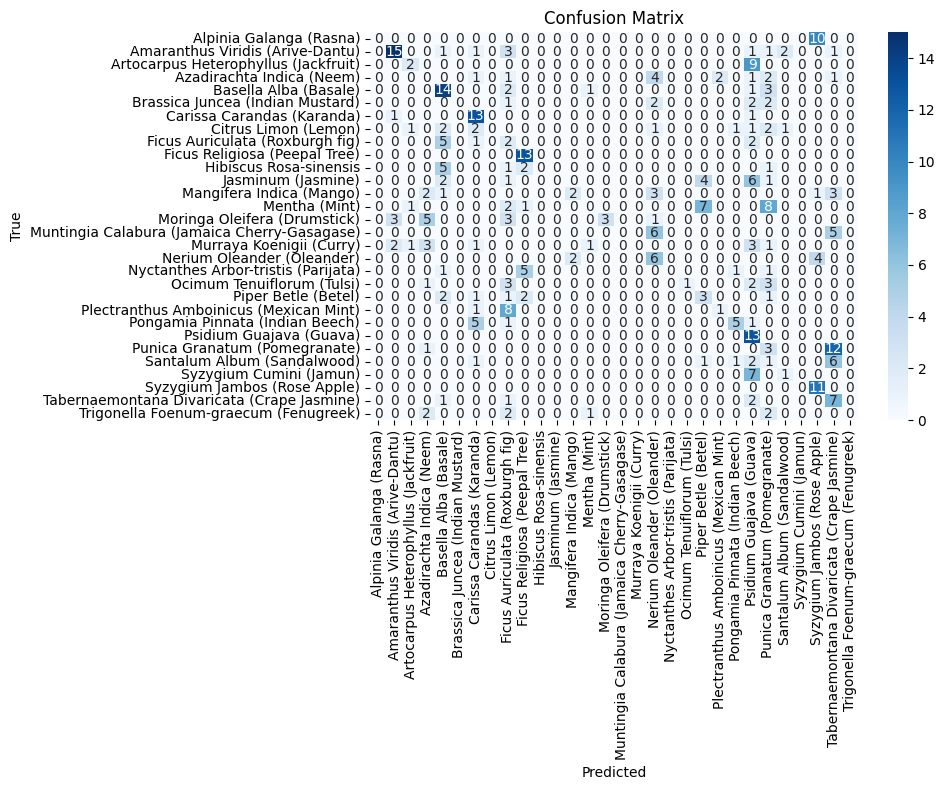

Epoch 1: Train Acc=0.08, Val Acc=0.31


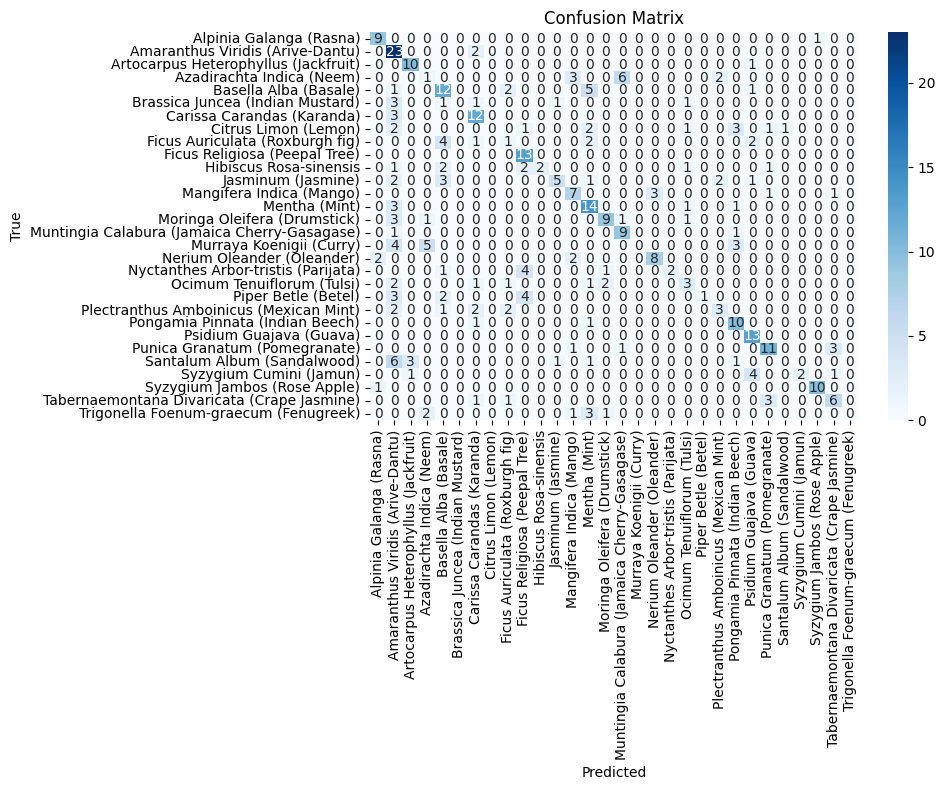

Epoch 2: Train Acc=0.33, Val Acc=0.53


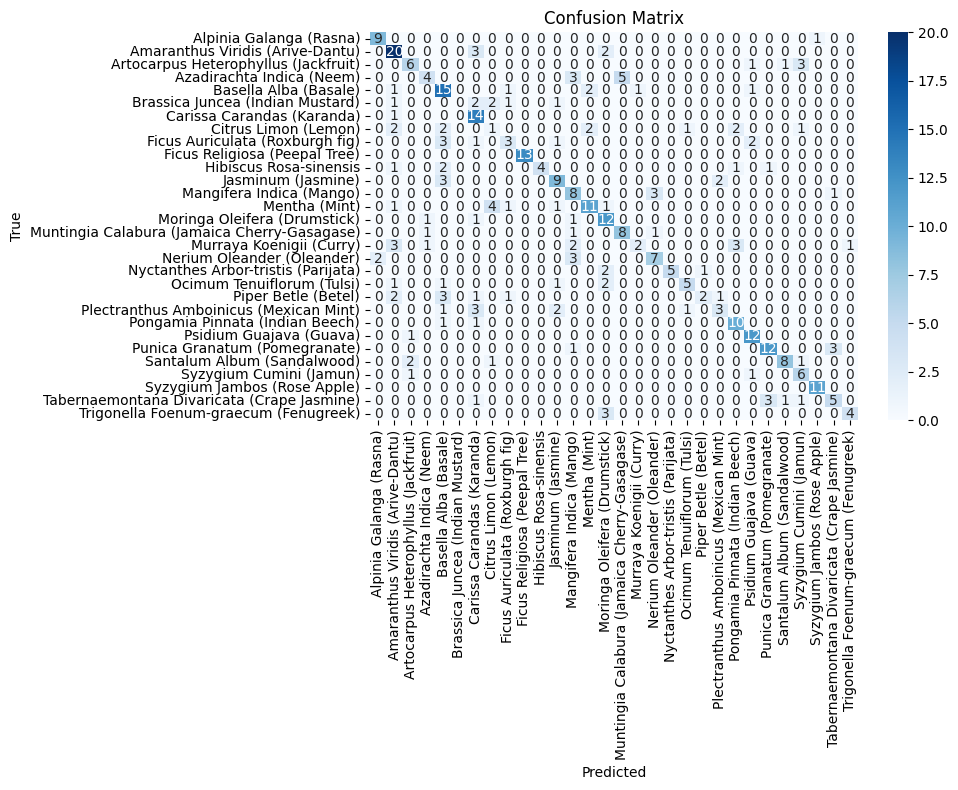

Epoch 3: Train Acc=0.50, Val Acc=0.62


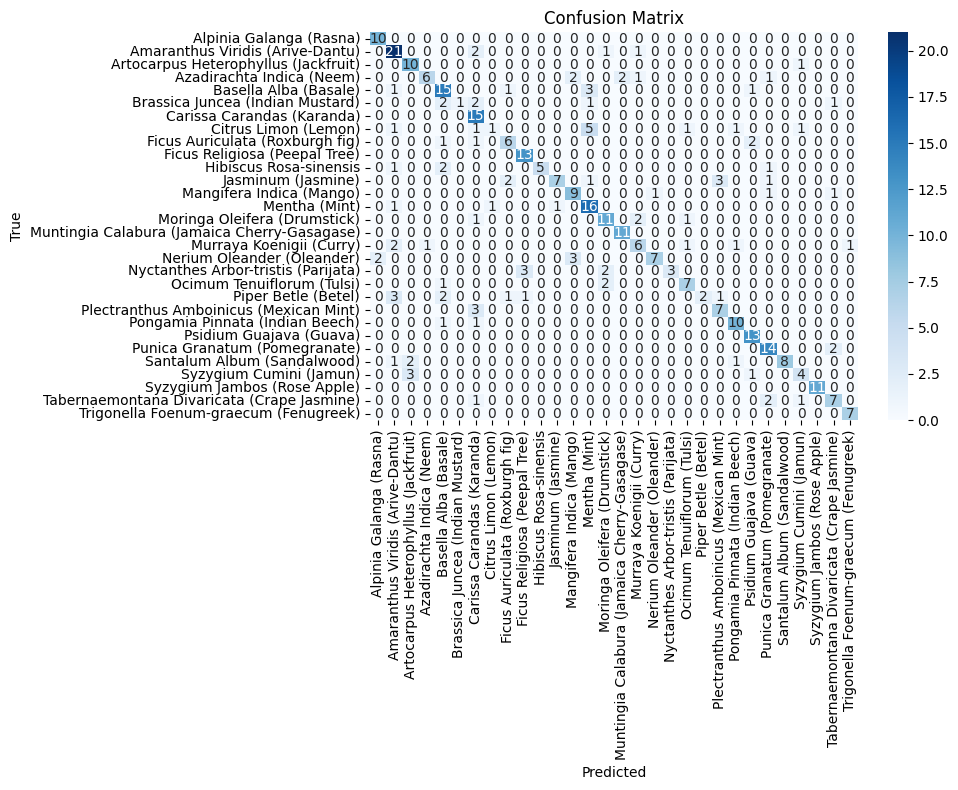

Epoch 4: Train Acc=0.59, Val Acc=0.72


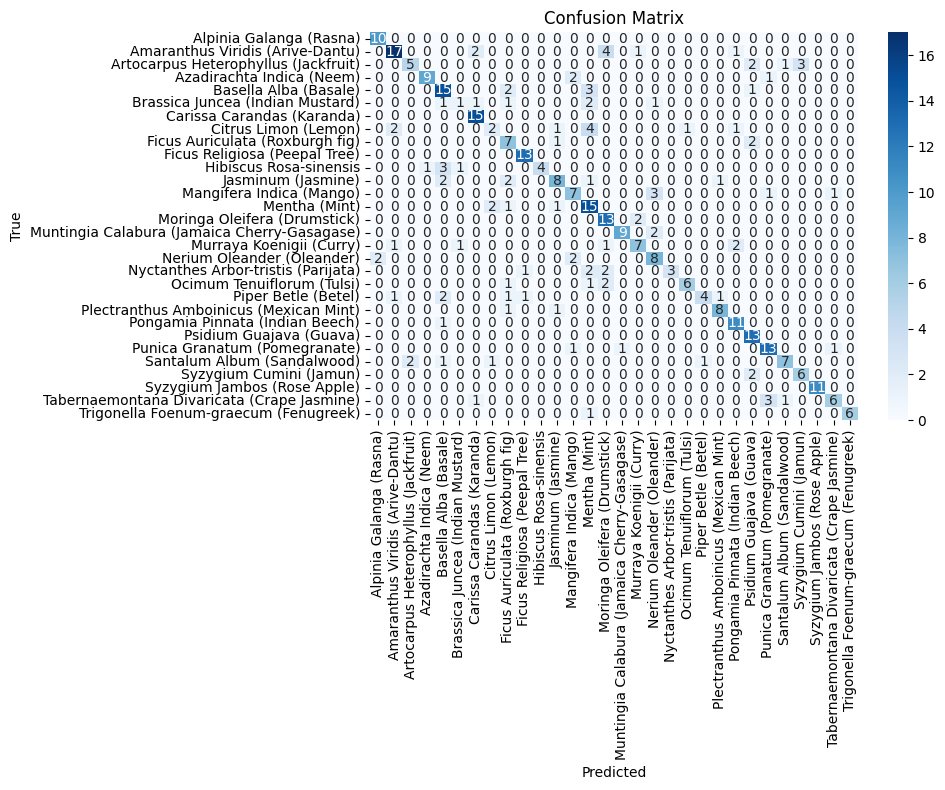

Epoch 5: Train Acc=0.66, Val Acc=0.71


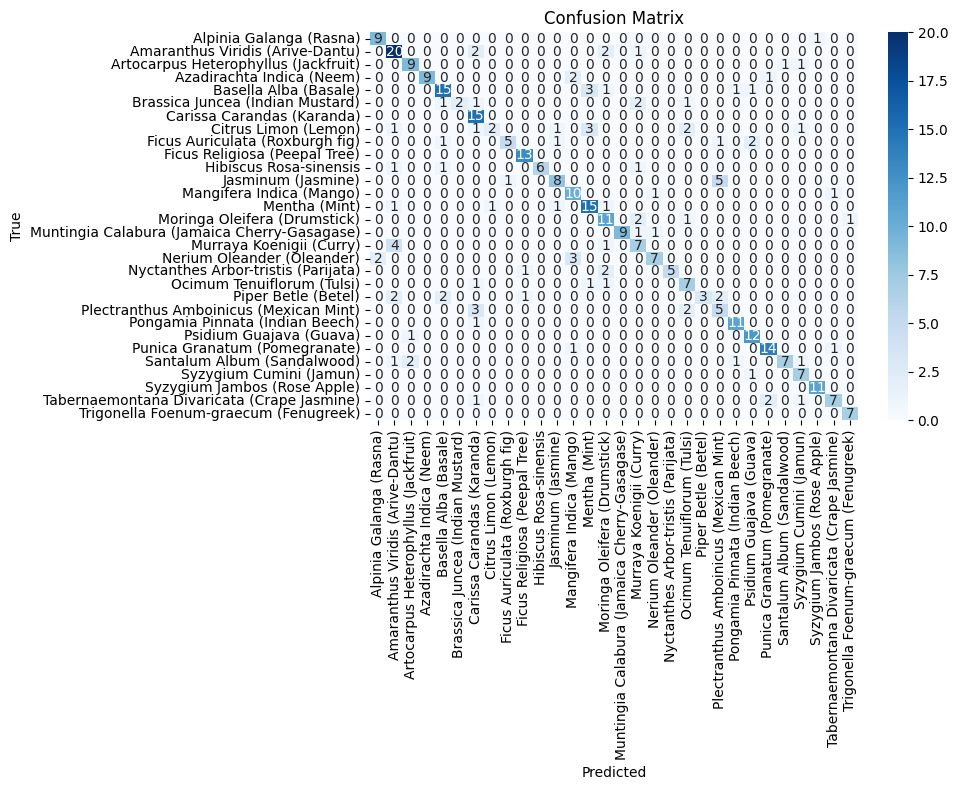

Epoch 6: Train Acc=0.70, Val Acc=0.73


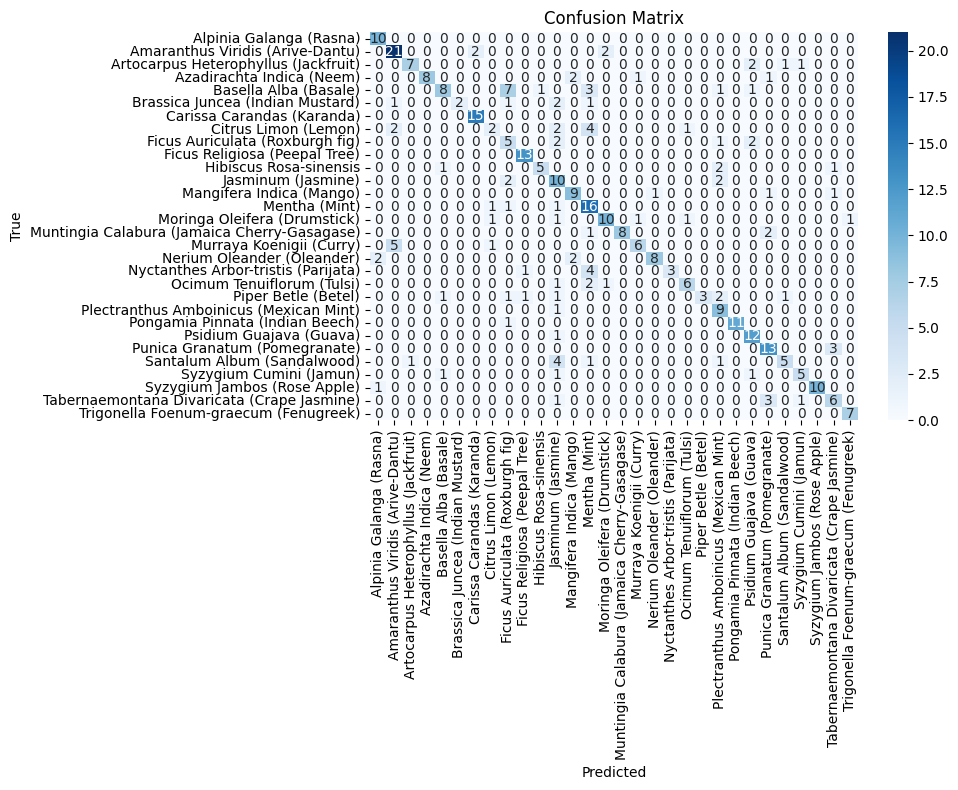

Epoch 7: Train Acc=0.75, Val Acc=0.69


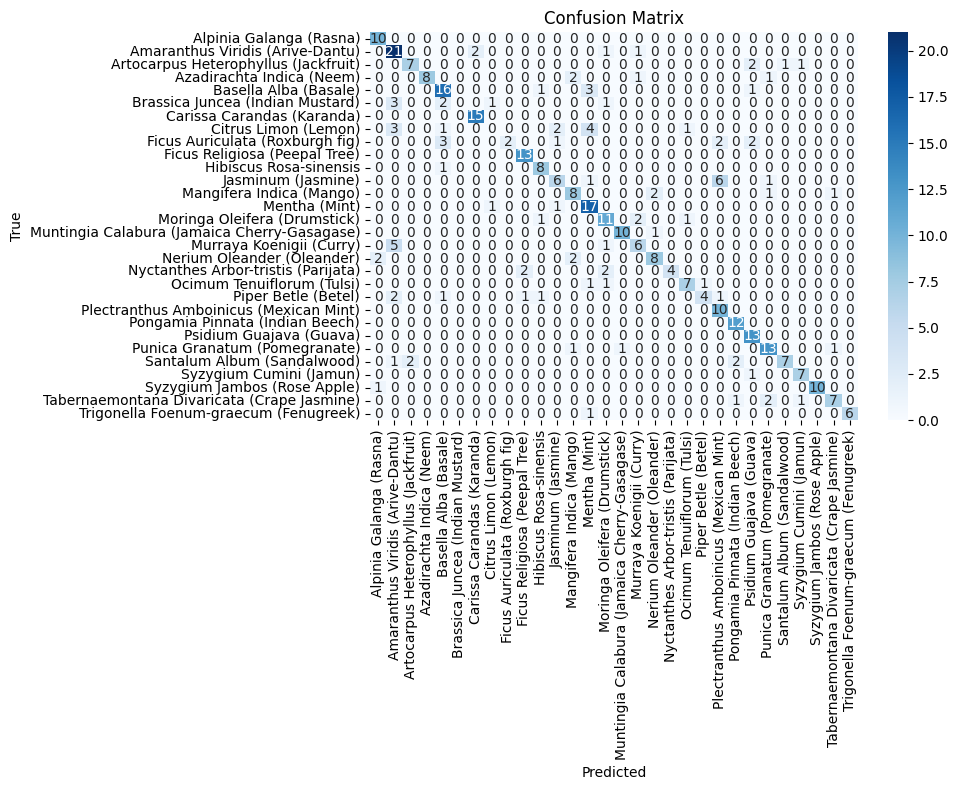

Epoch 8: Train Acc=0.76, Val Acc=0.72


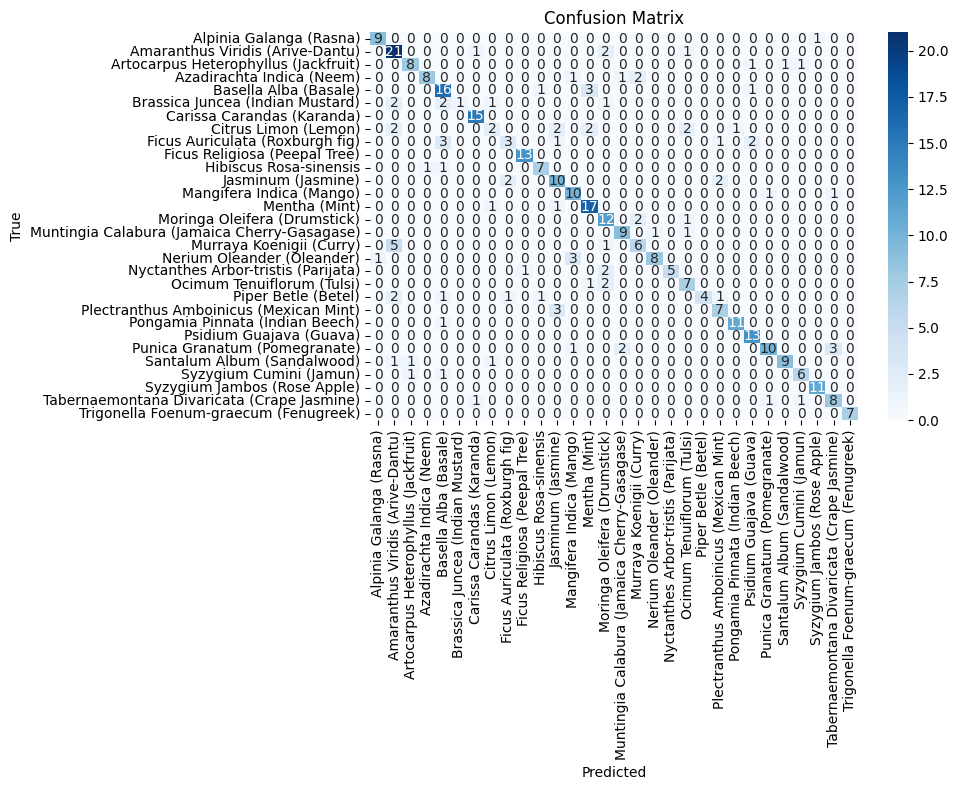

Epoch 9: Train Acc=0.79, Val Acc=0.74


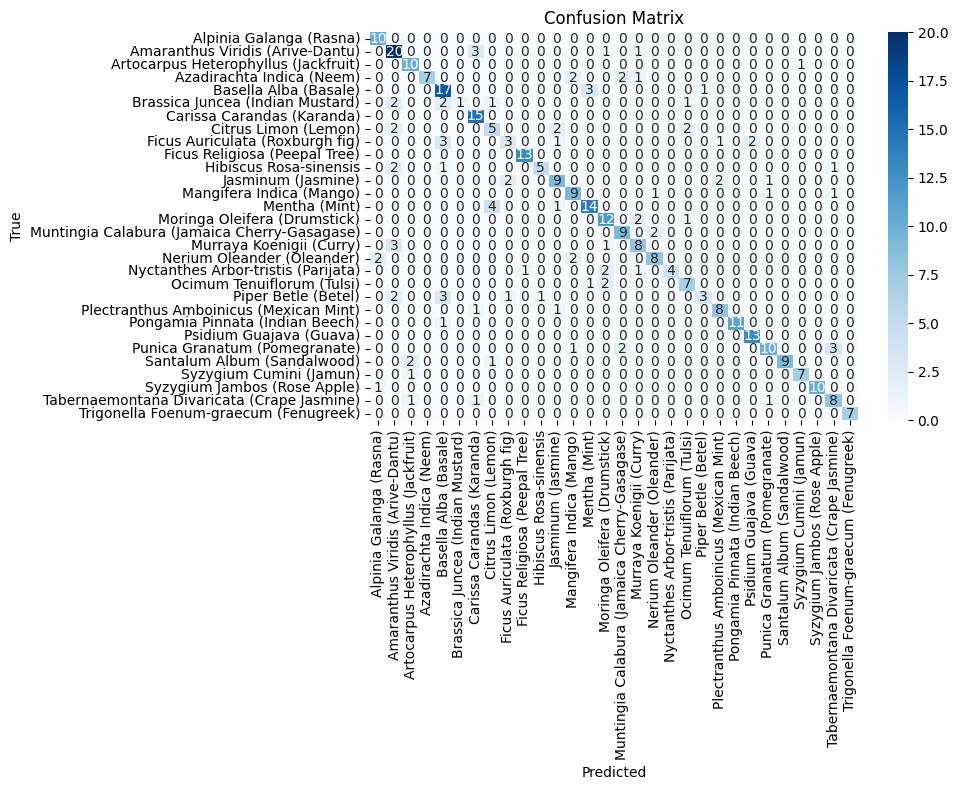

Epoch 10: Train Acc=0.84, Val Acc=0.74


In [5]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

rgb_dir = 'Output/rgb'
edge_dir = 'Output/edge'
venation_dir = 'Output/venation'

dataset = DualStreamFolderDataset(rgb_dir, edge_dir, venation_dir, transform)
class_names = list(dataset.class_to_idx.keys())

# Train-val split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.samples[i][3] for i in indices])

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=16, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=16, shuffle=False)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer, criterion = build_model(num_classes=len(class_names))
model.to(device)

# Training
for epoch in range(10):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, class_names)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")
